<a href="https://colab.research.google.com/github/JadhavShrutiS/CSCE580/blob/main/ProjB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages (Colab / fresh env)
!pip install -q -U transformers accelerate datasets evaluate scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 13.9 MB/s eta 0:00:00


In [ ]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)


(True, 'Tesla T4')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/JadhavShrutiS/CSCE580/refs/heads/main/Project-B/IMDB%20Dataset.csv"
df = pd.read_csv(url)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
from datasets import Dataset
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

ds = Dataset.from_pandas(df)

reviews = np.array(ds["review"])
sentiments = np.array(ds["sentiment"])
label_map = {"positive": 1, "negative": 0}
labels = np.array([label_map[x] for x in sentiments])

# 80% train, 20% holdout
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
train_idx, hold_idx = next(sss.split(reviews, labels))

hold_labels = labels[hold_idx]
hold_reviews = reviews[hold_idx]

# 50/50 val and test
val_idx, test_idx = train_test_split(
    np.arange(len(hold_reviews)),
    test_size=0.5,
    stratify=hold_labels,
    random_state=50
)

train_ds = Dataset.from_dict({
    "review": reviews[train_idx],
    "labels": labels[train_idx]
})

val_ds = Dataset.from_dict({
    "review": hold_reviews[val_idx],
    "labels": hold_labels[val_idx]
})

test_ds = Dataset.from_dict({
    "review": hold_reviews[test_idx],
    "labels": hold_labels[test_idx]
})


In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(
        batch["review"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_tok = train_ds.map(tokenize_fn, batched=True)
val_tok   = val_ds.map(tokenize_fn, batched=True)
test_tok  = test_ds.map(tokenize_fn, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [1]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

data_collator = DataCollatorWithPadding(tokenizer)

def compute_metrics(eval_pred):
    acc = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    prec = evaluate.load("precision")
    rec = evaluate.load("recall")

    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "precision": prec.compute(predictions=preds, references=labels)["precision"],
        "recall": rec.compute(predictions=preds, references=labels)["recall"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"]
    }

import os
os.environ["WANDB_DISABLED"] = "true"

output_dir = "/content/drive/MyDrive/CSCE580_ProjectB/distilbert_imdb"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    eval_strategy="epoch",
    weight_decay=0.01,
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

import time
start_time = time.time()
trainer.train()
end_time = time.time()
training_time = end_time - start_time
print(f"Training time (fine-tuned DistilBERT): {training_time:.2f} seconds")

KeyboardInterrupt: 

In [ ]:
save_dir = "/content/drive/MyDrive/CSCE580_ProjectB/distilbert_imdb"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

NameError: name 'trainer' is not defined

In [ ]:
trainer.evaluate(test_tok)

{'eval_loss': 0.21821193397045135,
 'eval_accuracy': 0.9158,
 'eval_precision': 0.9268993839835729,
 'eval_recall': 0.9028,
 'eval_f1': 0.9146909827760892,
 'eval_runtime': 39.6346,
 'eval_samples_per_second': 126.152,
 'eval_steps_per_second': 3.961,
 'epoch': 5.0}

In [ ]:
train_eval = trainer.evaluate(train_tok)
train_accuracy_value = train_eval["eval_accuracy"]

In [ ]:
train_accuracy_list = [(i+1, train_accuracy_value) for i in range(training_args.num_train_epochs)]


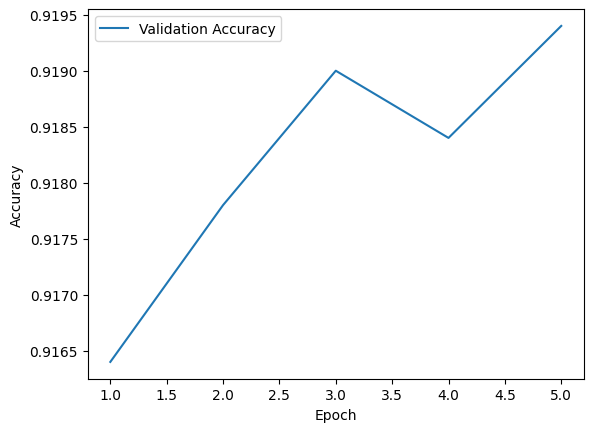

In [ ]:
# plt.plot([x[0] for x in train_accuracy_list],
        #  [x[1] for x in train_accuracy_list], label="Train Accuracy")

plt.plot(eval_acc_df["epoch"], eval_acc_df["eval_accuracy"], label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


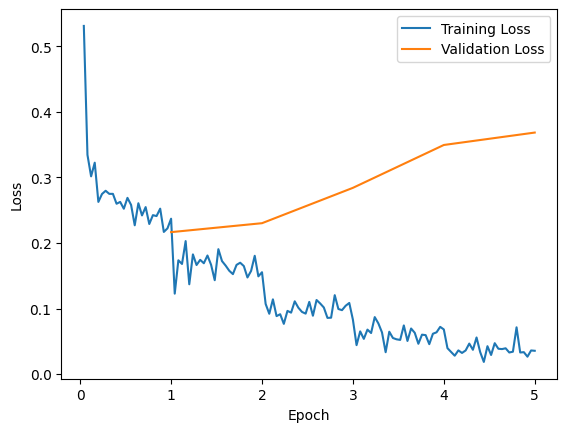

In [ ]:
plt.plot(train_loss_df["epoch"], train_loss_df["train_loss"], label="Training Loss")
plt.plot(eval_loss_df["epoch"], eval_loss_df["eval_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# history = trainer.state.log_history
# df_hist = pd.DataFrame(history)

# # Accuracy graph
# plt.figure(figsize=(6,4))
# plt.plot(df_hist["epoch"], df_hist["eval_accuracy"])
# plt.title("Validation Accuracy Over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.grid()
# plt.show()

# # Loss graph
# plt.figure(figsize=(6,4))
# plt.plot(df_hist["epoch"], df_hist["loss"], label="Train Loss")
# plt.plot(df_hist["epoch"], df_hist["eval_loss"], label="Validation Loss")
# plt.title("Training and Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "distilbert_finetuned_imdb"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

OSError: distilbert_finetuned_imdb is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

preds_output = trainer.predict(test_tok)
preds = np.argmax(preds_output.predictions, axis=-1)

cm = confusion_matrix(test_ds["labels"], preds)
print(cm)

print(classification_report(test_ds["labels"], preds, target_names=["negative","positive"]))

[[2322  178]
 [ 243 2257]]
              precision    recall  f1-score   support

    negative       0.91      0.93      0.92      2500
    positive       0.93      0.90      0.91      2500

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



In [ ]:
pretrained_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
)

pretrained_trainer = Trainer(
    model=pretrained_model,
    tokenizer=tokenizer,
    data_collator=data_collator
)

pre_preds_output = pretrained_trainer.predict(test_tok)
pre_preds = np.argmax(pre_preds_output.predictions, axis=-1)

print(confusion_matrix(test_ds["labels"], pre_preds))
print(classification_report(test_ds["labels"], pre_preds, target_names=["negative","positive"]))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2640211413.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  pretrained_trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


[[2466   34]
 [2466   34]]
              precision    recall  f1-score   support

    negative       0.50      0.99      0.66      2500
    positive       0.50      0.01      0.03      2500

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.35      5000
weighted avg       0.50      0.50      0.35      5000



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000)),
    ("svm", LinearSVC())
])


clf.fit(train_ds["review"], train_ds["labels"])
svm_preds = clf.predict(test_ds["review"])

print(confusion_matrix(test_ds["labels"], svm_preds))
print(classification_report(test_ds["labels"], svm_preds, target_names=["negative","positive"]))

[[2219  281]
 [ 254 2246]]
              precision    recall  f1-score   support

    negative       0.90      0.89      0.89      2500
    positive       0.89      0.90      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [ ]:
def predict_finetuned(text):
    import time
    start = time.time()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    inputs = {k: v.to(model.device) for k, v in inputs.items()} # Move inputs to model's device
    outputs = model(**inputs)
    pred = outputs.logits.argmax(dim=1).item()
    end = time.time()
    print(f"Inference time: {end -start:.4f} seconds")

    return "positive" if pred == 1 else "negative"

In [ ]:
def predict_pretrained(text):
    import time
    start = time.time()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    inputs = {k: v.to(model.device) for k, v in inputs.items()} # Move inputs to model's device

    outputs = pretrained_model(**inputs)
    pred = outputs.logits.argmax(dim=1).item()
    end = time.time()
    print(f"Inference time: {end -start:.4f} seconds")
    return "positive" if pred == 1 else "negative"

In [ ]:
def predict_svm(text):
    import time
    start = time.time()
    pred = clf.predict([text])[0]
    end = time.time()
    print(f"Inference time: {end -start:.4f} seconds")
    return "positive" if pred == 1 else "negative"

In [ ]:
predict_finetuned("The food was good")
print()
predict_pretrained("The food was good")
print()
predict_svm("The food was good")


NameError: name 'tokenizer' is not defined

In [ ]:
predict_pretrained("The food was good")

Inference time: 0.0140 seconds


'negative'

In [ ]:
predict_svm("The food was good")

Inference time: 0.0013 seconds


'positive'

In [ ]:
predict_pretrained("Okay")

Inference time: 0.0336 seconds


'positive'